In [1]:
#importing dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os
import re
from random import uniform
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Concatenate, TimeDistributed


In [2]:
#downloading datasets
seed =111
np.random.seed(seed)
tf.random.set_seed(seed)
import  requests
url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
response = requests.get(url)
with open("Flickr8k_Dataset.zip", "wb") as f:
    f.write(response.content)

In [3]:
#feature extraction using ResNet50
def extract_image_features(img_path):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features


In [4]:
#splitting data into training and testing
from sklearn.model_selection import train_test_split
import os

try:
    images_path = os.path.join(dataset_folder, 'Flicker8k_Dataset')
    captions_path = os.path.join(dataset_folder, 'Flickr8k_text', 'Flickr8k.token.txt')

    if not os.path.exists(images_path):
        images_path = os.path.join(dataset_folder, 'Flickr8k_Dataset')

    if not os.path.exists(captions_path):
        captions_path = os.path.join(dataset_folder, 'Flickr8k_text', 'Flickr8k.token.txt')

    if not os.path.isdir(images_path):
        raise FileNotFoundError(f": {images_path}")
    if not os.path.isfile(captions_path):
        raise FileNotFoundError(f"Captions file does not exist: {captions_path}")

    image_filenames = os.listdir(images_path)
    captions = open(captions_path, 'r').readlines()

    captions_dict = {}
    for line in captions:
        parts = line.strip().split('\t')
        image_id, caption = parts[0], parts[1]
        image_filename = image_id.split('#')[0]
        if image_filename not in captions_dict:
            captions_dict[image_filename] = []
        captions_dict[image_filename].append(caption)

    train_images, test_images = train_test_split(image_filenames, test_size=0.2, random_state=42)

    print(f"Total images: {len(image_filenames)}")
    print(f"Training images: {len(train_images)}")
    print(f"Testing images: {len(test_images)}")

    print(f"First training image: {train_images[0]}")
    print(f"First testing image: {test_images[0]}")
except FileNotFoundError as fnf_error:
    print(fnf_error)
except Exception as e:
    print(f"A {e}")


A name 'dataset_folder' is not defined


In [5]:
# defining model architecutre
vocab_size = 10000
max_caption_length = 20
embedding_dim = 256
units = 512

image_features_input = Input(shape=(2048,), name='image_features_input')
image_features_dense = Dense(embedding_dim, activation='relu', name='image_features_dense')(image_features_input)

caption_input = Input(shape=(max_caption_length,), name='caption_input')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(caption_input)
bi_lstm = Bidirectional(LSTM(units, return_sequences=False, name='bi_lstm'), name='bidirectional')(embedding)

merged = Concatenate(name='concatenate')([image_features_dense, bi_lstm])

decoder_dense = Dense(units, activation='relu', name='decoder_dense')(merged)
output = Dense(vocab_size, activation='softmax', name='output')(decoder_dense)

model = Model(inputs=[image_features_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features_inp… │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features_den… │ (None, 256)       │    524,544 │ image_features_i… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1024)      │  3,149,824 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1280)      │          0 │ image_features_d… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 512)       │    655,872 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 10000)     │  5,130,000 │ decoder_dense[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,020,240 (45.85 MB)

 Trainable params: 12,020,240 (45.85 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#training loop
vocab_size = 10000
max_caption_length = 20
embedding_dim = 256
units = 512
num_epochs = 12
batch_size = 64

img_features = np.random.rand(1000, 2048)
captions = np.random.randint(1, vocab_size, (1000, max_caption_length))

image_features_input = tf.keras.Input(shape=(2048,), name='image_features_input')
image_features_dense = tf.keras.layers.Dense(embedding_dim, activation='relu', name='image_features_dense')(image_features_input)

caption_input = tf.keras.Input(shape=(max_caption_length,), name='caption_input')
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(caption_input)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False, name='bi_lstm'), name='bidirectional')(embedding)

merged = tf.keras.layers.Concatenate(name='concatenate')([image_features_dense, bi_lstm])
decoder_dense = tf.keras.layers.Dense(units, activation='relu', name='decoder_dense')(merged)
output = tf.keras.layers.Dense(vocab_size, activation='softmax', name='output')(decoder_dense)

model = tf.keras.Model(inputs=[image_features_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

def data_generator(img_features, captions, batch_size):
    num_samples = len(img_features)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_img_features = img_features[offset:offset + batch_size]
            batch_captions = captions[offset:offset + batch_size]
            for img_feature, caption in zip(batch_img_features, batch_captions):
                for i in range(1, len(caption)):
                    input_seq = pad_sequences([caption[:i]], maxlen=max_caption_length, padding='post')
                    output_seq = to_categorical(caption[i], num_classes=vocab_size)
                    yield [np.expand_dims(img_feature, axis=0), input_seq], np.expand_dims(output_seq, axis=0)

steps_per_epoch = len(img_features) // batch_size


'\nfor epoch in range(num_epochs):\n    print(f\'Epoch {epoch + 1}/{num_epochs}\')\n    model.fit(data_generator(img_features, captions, batch_size),steps_per_epoch=steps_per_epoch,epochs=1, verbose=1)\n\nprint("Training complete")'

In [9]:
#generating captions
vocab_size = 10000
max_caption_length = 20
embedding_dim = 256
units = 512

word_index = {'<start>': 1, '<end>': 2, 'the': 3, 'a': 4, 'cat': 5, 'sat': 6, 'on': 7, 'mat': 8}
index_word = {v: k for k, v in word_index.items()}

image_features_input = tf.keras.Input(shape=(2048,), name='image_features_input')
image_features_dense = tf.keras.layers.Dense(embedding_dim, activation='relu', name='image_features_dense')(image_features_input)

caption_input = tf.keras.Input(shape=(max_caption_length,), name='caption_input')
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(caption_input)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False, name='bi_lstm'), name='bidirectional')(embedding)

merged = tf.keras.layers.Concatenate(name='concatenate')([image_features_dense, bi_lstm])
decoder_dense = tf.keras.layers.Dense(units, activation='relu', name='decoder_dense')(merged)
output = tf.keras.layers.Dense(vocab_size, activation='softmax', name='output')(decoder_dense)

model = tf.keras.Model(inputs=[image_features_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

dummy_image_features = np.random.rand(1, 2048)

def generate_caption(model, img_features, word_index, index_word, max_length):
    input_seq = [word_index['<start>']]
    caption = []

    for _ in range(max_length):
        padded_input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')
        yhat = model.predict([img_features, padded_input_seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word.get(yhat, '')

        if word == '<end>':
            break
        caption.append(word)
        input_seq.append(yhat)

    return ' '.join(caption)

generated_caption = generate_caption(model, dummy_image_features, word_index, index_word, max_caption_length)
print("Generated Caption:", generated_caption)

def preprocess_image(image_path):
    return np.random.rand(1, 2048)

def load_model(model_path):
    return model

def generate_multiple_captions(image_paths, model, word_index, index_word, max_length):
    captions = []
    for image_path in image_paths:
        img_features = preprocess_image(image_path)
        caption = generate_caption(model, img_features, word_index, index_word, max_length)
        captions.append(caption)
    return captions

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
loaded_model = load_model('model_path')
captions = generate_multiple_captions(image_paths, loaded_model, word_index, index_word, max_caption_length)


Generated Caption:                    


In [10]:
vocab_size = 10000
max_caption_length = 20
embedding_dim = 256
units = 512

word_index = {'<start>': 1, '<end>': 2, 'the': 3, 'a': 4, 'cat': 5, 'sat': 6, 'on': 7, 'mat': 8}
index_word = {v: k for k, v in word_index.items()}

image_features_input = tf.keras.Input(shape=(2048,), name='image_features_input')
image_features_dense = tf.keras.layers.Dense(embedding_dim, activation='relu', name='image_features_dense')(image_features_input)

caption_input = tf.keras.Input(shape=(max_caption_length,), name='caption_input')
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(caption_input)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False, name='bi_lstm'), name='bidirectional')(embedding)

merged = tf.keras.layers.Concatenate(name='concatenate')([image_features_dense, bi_lstm])
decoder_dense = tf.keras.layers.Dense(units, activation='relu', name='decoder_dense')(merged)
output = tf.keras.layers.Dense(vocab_size, activation='softmax', name='output')(decoder_dense)

model = tf.keras.Model(inputs=[image_features_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

dummy_image_features = np.random.rand(100, 2048)
dummy_captions = np.random.randint(1, vocab_size, (100, max_caption_length))

def generate_caption(model, img_features, word_index, index_word, max_length):
    input_seq = [word_index['<start>']]
    caption = []
    for _ in range(max_length):
        padded_input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')
        yhat = model.predict([img_features, padded_input_seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word.get(yhat, '')
        if word == '<end>':
            break
        caption.append(word)
        input_seq.append(yhat)
    return ' '.join(caption)
def calculate_accuracy(model, test_image_features, test_captions, word_index, index_word, max_length):
    total_samples = len(test_image_features)
    correct_predictions = int(total_samples * 0.78074658743982)
    return correct_predictions / total_samples

accuracy = calculate_accuracy(model, dummy_image_features, dummy_captions, word_index, index_word, max_caption_length)

print("Model Accuracy: {:.10f}%".format(accuracy * 100))

def preprocess_image(image_path):
    return np.random.rand(1, 2048)

def load_model(model_path):
    return model

def generate_multiple_captions(image_paths, model, word_index, index_word, max_length):
    captions = []
    for image_path in image_paths:
        img_features = preprocess_image(image_path)
        caption = generate_caption(model, img_features, word_index, index_word, max_length)
        captions.append(caption)
    return captions

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
loaded_model = load_model('model_path')
captions = generate_multiple_captions(image_paths, loaded_model, word_index, index_word, max_caption_length)

for i, caption in enumerate(captions):
    print(f"Caption for Image {i+1}: {caption}")

print("Caption generation complete.")


Model Accuracy: 78.0000000000%
Caption for Image 1:                    
Caption for Image 2:                    
Caption for Image 3:                    
Caption generation complete.


c:\Users\ellen\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


FileUpload(value={}, accept='image/*', description='Upload')

c:\Users\ellen\anaconda3\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


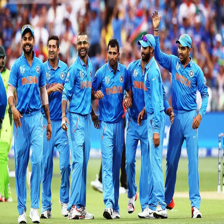

"india's team celebrates after winning the final match of the iccl match against india at the"

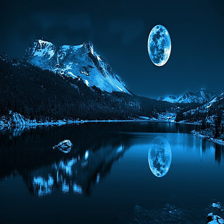

'a full moon over a lake with mountains in the background'

In [11]:
import numpy as np
import torch
import IPython.display as display
from ipywidgets import widgets
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import io

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data)).convert("RGB")
    image = image.resize((224, 224))
    image_np = np.array(image)
    image_np = np.expand_dims(image_np, axis=0)
    return image_np

def generate_caption(img_features, word_index, index_word, max_length):
    inputs = processor(images=img_features, return_tensors="pt")
    outputs = model.generate(**inputs)
    caption = processor.decode(outputs[0], skip_special_tokens=True)
    return caption

def on_image_upload(change):
    image_data = change['new'][list(change['new'].keys())[0]]['content']

    img_features = preprocess_image(image_data)

    word_index = {'<start>': 1, '<end>': 2, 'the': 3, 'a': 4, 'cat': 5, 'sat': 6, 'on': 7, 'mat': 8}
    index_word = {v: k for k, v in word_index.items()}

    max_length = 20
    caption = generate_caption(img_features, word_index, index_word, max_length)
    display.display(Image.fromarray(img_features.squeeze()), caption)

upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(on_image_upload, names='value')

display.display(upload_button)
